Test Env:
 - test game
 - test agent

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import pandas as pd

In [2]:
from game import StaticGame

In [3]:
game_example = StaticGame()

In [4]:
game_example.reset()

In [5]:
game_example.player_choices

{'seller': None, 'buyer': None}

In [6]:
game_example.car_type

'peach'

In [7]:
game_example.step('seller', 'low_price')

In [8]:
game_example.player_choices

{'seller': 'low_price', 'buyer': None}

In [9]:
game_example.step('buyer', 'buy')

In [10]:
game_example.player_choices

{'seller': 'low_price', 'buyer': 'buy'}

In [11]:
game_example.reward()

{'seller': -8.5, 'buyer': 10.5}

In [12]:
from agents import EpsGreedyAgent

In [13]:
agent = EpsGreedyAgent(name='seller')

In [14]:
agent.player_type

'seller'

In [15]:
agent.choose_action('lemon')

'low_price'

In [16]:
agent.update('peach', 'high_price', 'lemon', 0.5)

In [17]:
agent.qval

defaultdict(<function agents.EpsGreedyAgent.<lambda>()>,
            {'peach': array([0.05, 0.  ]), 'lemon': array([0., 0.])})

# Game imitation with Bots

Вероятность того, что стратегия будет выбрана случайно, определяется по формуле:

$$ \epsilon = \max(\epsilon \cdot decay \cdot time, minEpsilon),$$

где 

- $minEpsilon$ - минимально возможное значение вероятности выбора стратегии случайно,
- $time$ - количество раз, когда стратегия выбиралась игроком случайно.

In [18]:
import matplotlib. pyplot as plt

In [19]:
def compute_eps(x, epsilon=0.8, decay=0.9, min_epsilon=0.01):
    return max(epsilon * (decay ** x), min_epsilon)

In [20]:
n_times = 100
y = [compute_eps(x) for x in range(1, n_times)]
y_1 = [compute_eps(x, epsilon=0.5, decay=0.95) for x in range(1, n_times)]

Text(0.5, 1.0, 'Скорость убывания epsilon в зависимости от номера шага.')

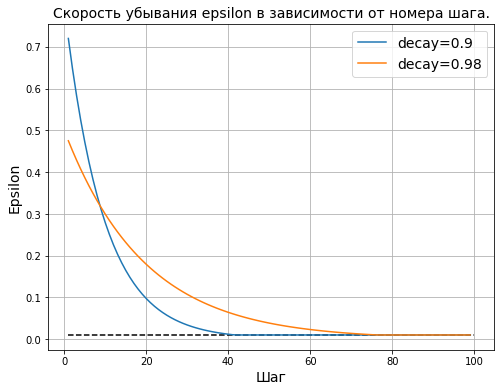

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, n_times), y, label='decay=0.9')
plt.plot(range(1, n_times), y_1, label='decay=0.98')
plt.hlines(0.01, 1, n_times, linestyle='--')
plt.grid()
plt.xlabel('Шаг', fontsize=14)
plt.ylabel('Epsilon', fontsize=14)
plt.legend(fontsize=14)
plt.title('Скорость убывания epsilon в зависимости от номера шага.', fontsize=14)

In [47]:
from config import *

In [319]:
# fully fair
qval_init_seller = {
    'lemon': [0, 10],
    'peach': [10, 0],
}
agent_seller = EpsGreedyAgent(name='seller', qval=qval_init_seller, epsilon=0.5, 
                              decay=0.9, min_epsilon=0.05, lr=0.1)
# fully trusting
qval_init_buyer = {
    'high_price': [0, 1],
    'low_price': [1, 0],
}
agent_buyer = EpsGreedyAgent(name='buyer', qval=qval_init_buyer, epsilon=0.5, 
                             decay=0.8, min_epsilon=0.05, lr=0.6)
game = StaticGame()
prev_seller = dict()
prev_buyer = dict()
is_prev = False
total_rewards = {'seller': [], 'buyer': []}
qvalues = {
    'seller': {
        'lemon': [],
        'peach': [],
    }, 
    'buyer': {
        'high_price': [],
        'low_price': [],
    }
}
n_iters = 5000
# lemon-peach, high_price-low_price, buy-not_buy
stats = np.zeros((n_iters, 3))
seller_eqv_step = None
buyer_eqv_step = None

for step in range(n_iters):
    game.reset()

    seller_action = agent_seller.choose_action(game.car_type)
    game.step('seller', seller_action)
    buyer_action = agent_buyer.choose_action(seller_action)
    game.step('buyer', buyer_action)
    print('Step #', '\t', step, '\t', game.car_type, '\t', 
          seller_action, '\t', buyer_action)

    if is_prev:
        agent_seller.update(prev_seller['obs'], prev_seller['action'], 
                            game.car_type, prev_seller['reward'])
        agent_buyer.update(prev_buyer['obs'], prev_buyer['action'], 
                           seller_action, prev_buyer['reward'])

    if agent_seller.epsilon == 0.05 and seller_eqv_step is None:
        seller_eqv_step = step
    if agent_buyer.epsilon == 0.05 and buyer_eqv_step is None:
        buyer_eqv_step = step

    prev_seller['obs'] = game.car_type
    prev_seller['action'] = seller_action
    prev_seller['reward'] = game.reward('seller')
    
    prev_buyer['obs'] = seller_action
    prev_buyer['action'] = buyer_action
    prev_buyer['reward'] = game.reward('buyer')
    is_prev = True

    # total rewards
    total_rewards['seller'].append(game.reward('seller'))
    total_rewards['buyer'].append(game.reward('buyer'))
    
    # history q_values
    qvalues['seller']['lemon'].append(list(agent_seller.qval['lemon']))
    qvalues['seller']['peach'].append(list(agent_seller.qval['peach']))
    qvalues['buyer']['high_price'].append(list(agent_buyer.qval['high_price']))
    qvalues['buyer']['low_price'].append(list(agent_buyer.qval['low_price']))
    
    # stats for honesty and trust computing
    stats[step, 0] = CAR_TYPE_TO_ID[game.car_type]
    stats[step, 1] = ACTION_TO_ID['seller'][seller_action]
    stats[step, 2] = ACTION_TO_ID['buyer'][buyer_action]

Step # 	 0 	 peach 	 high_price 	 not_buy
Step # 	 1 	 lemon 	 low_price 	 not_buy
Step # 	 2 	 peach 	 high_price 	 not_buy
Step # 	 3 	 peach 	 low_price 	 buy
Step # 	 4 	 peach 	 high_price 	 not_buy
Step # 	 5 	 peach 	 high_price 	 not_buy
Step # 	 6 	 lemon 	 high_price 	 buy
Step # 	 7 	 lemon 	 low_price 	 buy
Step # 	 8 	 lemon 	 low_price 	 buy
Step # 	 9 	 peach 	 high_price 	 not_buy
Step # 	 10 	 peach 	 low_price 	 buy
Step # 	 11 	 peach 	 high_price 	 not_buy
Step # 	 12 	 peach 	 high_price 	 buy
Step # 	 13 	 peach 	 high_price 	 not_buy
Step # 	 14 	 lemon 	 low_price 	 buy
Step # 	 15 	 lemon 	 low_price 	 not_buy
Step # 	 16 	 peach 	 low_price 	 buy
Step # 	 17 	 peach 	 high_price 	 not_buy
Step # 	 18 	 lemon 	 low_price 	 buy
Step # 	 19 	 peach 	 high_price 	 not_buy
Step # 	 20 	 peach 	 high_price 	 not_buy
Step # 	 21 	 peach 	 low_price 	 buy
Step # 	 22 	 peach 	 high_price 	 not_buy
Step # 	 23 	 peach 	 high_price 	 not_buy
Step # 	 24 	 lemon 	 low_pr

Step # 	 333 	 lemon 	 low_price 	 buy
Step # 	 334 	 peach 	 high_price 	 not_buy
Step # 	 335 	 lemon 	 low_price 	 buy
Step # 	 336 	 lemon 	 low_price 	 buy
Step # 	 337 	 lemon 	 low_price 	 buy
Step # 	 338 	 peach 	 high_price 	 not_buy
Step # 	 339 	 peach 	 high_price 	 not_buy
Step # 	 340 	 lemon 	 low_price 	 buy
Step # 	 341 	 peach 	 low_price 	 buy
Step # 	 342 	 peach 	 high_price 	 not_buy
Step # 	 343 	 peach 	 high_price 	 not_buy
Step # 	 344 	 peach 	 high_price 	 not_buy
Step # 	 345 	 peach 	 high_price 	 not_buy
Step # 	 346 	 lemon 	 low_price 	 buy
Step # 	 347 	 lemon 	 low_price 	 buy
Step # 	 348 	 peach 	 high_price 	 not_buy
Step # 	 349 	 peach 	 high_price 	 not_buy
Step # 	 350 	 peach 	 high_price 	 not_buy
Step # 	 351 	 peach 	 high_price 	 not_buy
Step # 	 352 	 peach 	 high_price 	 not_buy
Step # 	 353 	 peach 	 high_price 	 not_buy
Step # 	 354 	 lemon 	 low_price 	 buy
Step # 	 355 	 peach 	 high_price 	 not_buy
Step # 	 356 	 peach 	 high_price

Step # 	 666 	 peach 	 high_price 	 not_buy
Step # 	 667 	 peach 	 high_price 	 not_buy
Step # 	 668 	 peach 	 high_price 	 not_buy
Step # 	 669 	 peach 	 high_price 	 not_buy
Step # 	 670 	 peach 	 low_price 	 buy
Step # 	 671 	 peach 	 low_price 	 buy
Step # 	 672 	 peach 	 high_price 	 not_buy
Step # 	 673 	 lemon 	 low_price 	 buy
Step # 	 674 	 peach 	 high_price 	 not_buy
Step # 	 675 	 peach 	 high_price 	 not_buy
Step # 	 676 	 peach 	 high_price 	 not_buy
Step # 	 677 	 peach 	 high_price 	 not_buy
Step # 	 678 	 lemon 	 low_price 	 buy
Step # 	 679 	 peach 	 high_price 	 not_buy
Step # 	 680 	 peach 	 high_price 	 not_buy
Step # 	 681 	 peach 	 high_price 	 not_buy
Step # 	 682 	 peach 	 high_price 	 not_buy
Step # 	 683 	 peach 	 high_price 	 not_buy
Step # 	 684 	 peach 	 high_price 	 not_buy
Step # 	 685 	 peach 	 high_price 	 not_buy
Step # 	 686 	 peach 	 high_price 	 not_buy
Step # 	 687 	 peach 	 high_price 	 not_buy
Step # 	 688 	 peach 	 high_price 	 not_buy
Step # 	

Step # 	 981 	 peach 	 high_price 	 not_buy
Step # 	 982 	 peach 	 low_price 	 buy
Step # 	 983 	 peach 	 high_price 	 not_buy
Step # 	 984 	 peach 	 high_price 	 not_buy
Step # 	 985 	 peach 	 high_price 	 not_buy
Step # 	 986 	 peach 	 high_price 	 not_buy
Step # 	 987 	 peach 	 high_price 	 not_buy
Step # 	 988 	 peach 	 high_price 	 not_buy
Step # 	 989 	 lemon 	 low_price 	 buy
Step # 	 990 	 peach 	 high_price 	 not_buy
Step # 	 991 	 lemon 	 low_price 	 buy
Step # 	 992 	 peach 	 high_price 	 not_buy
Step # 	 993 	 lemon 	 low_price 	 buy
Step # 	 994 	 lemon 	 low_price 	 buy
Step # 	 995 	 peach 	 high_price 	 not_buy
Step # 	 996 	 peach 	 high_price 	 not_buy
Step # 	 997 	 peach 	 low_price 	 buy
Step # 	 998 	 peach 	 high_price 	 not_buy
Step # 	 999 	 peach 	 high_price 	 not_buy
Step # 	 1000 	 peach 	 high_price 	 not_buy
Step # 	 1001 	 peach 	 high_price 	 not_buy
Step # 	 1002 	 peach 	 high_price 	 not_buy
Step # 	 1003 	 peach 	 high_price 	 not_buy
Step # 	 1004 

Step # 	 1320 	 lemon 	 low_price 	 buy
Step # 	 1321 	 peach 	 high_price 	 not_buy
Step # 	 1322 	 peach 	 high_price 	 not_buy
Step # 	 1323 	 peach 	 high_price 	 not_buy
Step # 	 1324 	 peach 	 high_price 	 not_buy
Step # 	 1325 	 peach 	 high_price 	 not_buy
Step # 	 1326 	 peach 	 high_price 	 not_buy
Step # 	 1327 	 peach 	 high_price 	 buy
Step # 	 1328 	 peach 	 high_price 	 not_buy
Step # 	 1329 	 lemon 	 high_price 	 not_buy
Step # 	 1330 	 peach 	 high_price 	 not_buy
Step # 	 1331 	 peach 	 high_price 	 not_buy
Step # 	 1332 	 lemon 	 low_price 	 buy
Step # 	 1333 	 lemon 	 low_price 	 buy
Step # 	 1334 	 peach 	 high_price 	 not_buy
Step # 	 1335 	 peach 	 high_price 	 not_buy
Step # 	 1336 	 peach 	 high_price 	 not_buy
Step # 	 1337 	 peach 	 high_price 	 not_buy
Step # 	 1338 	 peach 	 high_price 	 not_buy
Step # 	 1339 	 lemon 	 low_price 	 buy
Step # 	 1340 	 lemon 	 low_price 	 buy
Step # 	 1341 	 peach 	 high_price 	 not_buy
Step # 	 1342 	 peach 	 high_price 	 no

Step # 	 1615 	 peach 	 high_price 	 not_buy
Step # 	 1616 	 peach 	 high_price 	 not_buy
Step # 	 1617 	 peach 	 high_price 	 not_buy
Step # 	 1618 	 peach 	 high_price 	 not_buy
Step # 	 1619 	 lemon 	 low_price 	 buy
Step # 	 1620 	 peach 	 high_price 	 not_buy
Step # 	 1621 	 peach 	 high_price 	 not_buy
Step # 	 1622 	 peach 	 high_price 	 not_buy
Step # 	 1623 	 peach 	 high_price 	 not_buy
Step # 	 1624 	 peach 	 high_price 	 not_buy
Step # 	 1625 	 peach 	 high_price 	 not_buy
Step # 	 1626 	 peach 	 high_price 	 not_buy
Step # 	 1627 	 peach 	 high_price 	 not_buy
Step # 	 1628 	 peach 	 high_price 	 not_buy
Step # 	 1629 	 peach 	 high_price 	 not_buy
Step # 	 1630 	 peach 	 high_price 	 not_buy
Step # 	 1631 	 peach 	 high_price 	 not_buy
Step # 	 1632 	 lemon 	 low_price 	 buy
Step # 	 1633 	 peach 	 high_price 	 not_buy
Step # 	 1634 	 peach 	 high_price 	 not_buy
Step # 	 1635 	 peach 	 high_price 	 not_buy
Step # 	 1636 	 peach 	 high_price 	 not_buy
Step # 	 1637 	 peac

Step # 	 1944 	 peach 	 high_price 	 not_buy
Step # 	 1945 	 peach 	 high_price 	 not_buy
Step # 	 1946 	 peach 	 high_price 	 not_buy
Step # 	 1947 	 peach 	 high_price 	 not_buy
Step # 	 1948 	 peach 	 high_price 	 not_buy
Step # 	 1949 	 lemon 	 low_price 	 buy
Step # 	 1950 	 lemon 	 low_price 	 buy
Step # 	 1951 	 lemon 	 low_price 	 buy
Step # 	 1952 	 lemon 	 low_price 	 buy
Step # 	 1953 	 lemon 	 low_price 	 buy
Step # 	 1954 	 peach 	 high_price 	 not_buy
Step # 	 1955 	 peach 	 high_price 	 not_buy
Step # 	 1956 	 peach 	 high_price 	 not_buy
Step # 	 1957 	 lemon 	 low_price 	 buy
Step # 	 1958 	 peach 	 high_price 	 not_buy
Step # 	 1959 	 peach 	 high_price 	 not_buy
Step # 	 1960 	 peach 	 high_price 	 not_buy
Step # 	 1961 	 lemon 	 low_price 	 buy
Step # 	 1962 	 lemon 	 low_price 	 buy
Step # 	 1963 	 lemon 	 low_price 	 buy
Step # 	 1964 	 peach 	 high_price 	 not_buy
Step # 	 1965 	 peach 	 high_price 	 not_buy
Step # 	 1966 	 lemon 	 low_price 	 buy
Step # 	 1967 	

Step # 	 2288 	 peach 	 high_price 	 not_buy
Step # 	 2289 	 peach 	 high_price 	 not_buy
Step # 	 2290 	 peach 	 high_price 	 not_buy
Step # 	 2291 	 peach 	 low_price 	 buy
Step # 	 2292 	 peach 	 high_price 	 not_buy
Step # 	 2293 	 peach 	 high_price 	 not_buy
Step # 	 2294 	 lemon 	 low_price 	 buy
Step # 	 2295 	 peach 	 high_price 	 not_buy
Step # 	 2296 	 peach 	 high_price 	 not_buy
Step # 	 2297 	 peach 	 high_price 	 not_buy
Step # 	 2298 	 peach 	 high_price 	 not_buy
Step # 	 2299 	 peach 	 high_price 	 not_buy
Step # 	 2300 	 peach 	 high_price 	 not_buy
Step # 	 2301 	 lemon 	 low_price 	 buy
Step # 	 2302 	 lemon 	 low_price 	 buy
Step # 	 2303 	 peach 	 high_price 	 not_buy
Step # 	 2304 	 peach 	 high_price 	 not_buy
Step # 	 2305 	 peach 	 high_price 	 not_buy
Step # 	 2306 	 lemon 	 low_price 	 buy
Step # 	 2307 	 peach 	 high_price 	 not_buy
Step # 	 2308 	 peach 	 low_price 	 buy
Step # 	 2309 	 peach 	 high_price 	 not_buy
Step # 	 2310 	 lemon 	 low_price 	 buy


Step # 	 2625 	 peach 	 high_price 	 buy
Step # 	 2626 	 peach 	 high_price 	 buy
Step # 	 2627 	 peach 	 high_price 	 buy
Step # 	 2628 	 peach 	 high_price 	 buy
Step # 	 2629 	 peach 	 high_price 	 buy
Step # 	 2630 	 peach 	 high_price 	 buy
Step # 	 2631 	 peach 	 high_price 	 buy
Step # 	 2632 	 peach 	 high_price 	 buy
Step # 	 2633 	 peach 	 high_price 	 buy
Step # 	 2634 	 peach 	 high_price 	 buy
Step # 	 2635 	 peach 	 high_price 	 buy
Step # 	 2636 	 peach 	 high_price 	 buy
Step # 	 2637 	 lemon 	 low_price 	 buy
Step # 	 2638 	 peach 	 high_price 	 buy
Step # 	 2639 	 peach 	 high_price 	 buy
Step # 	 2640 	 peach 	 high_price 	 buy
Step # 	 2641 	 peach 	 high_price 	 buy
Step # 	 2642 	 peach 	 high_price 	 buy
Step # 	 2643 	 peach 	 high_price 	 buy
Step # 	 2644 	 lemon 	 low_price 	 buy
Step # 	 2645 	 peach 	 high_price 	 not_buy
Step # 	 2646 	 peach 	 high_price 	 buy
Step # 	 2647 	 peach 	 high_price 	 buy
Step # 	 2648 	 peach 	 high_price 	 buy
Step # 	 2649 

Step # 	 2991 	 peach 	 high_price 	 buy
Step # 	 2992 	 peach 	 high_price 	 buy
Step # 	 2993 	 lemon 	 low_price 	 buy
Step # 	 2994 	 peach 	 high_price 	 buy
Step # 	 2995 	 peach 	 high_price 	 buy
Step # 	 2996 	 lemon 	 low_price 	 buy
Step # 	 2997 	 peach 	 high_price 	 buy
Step # 	 2998 	 peach 	 high_price 	 buy
Step # 	 2999 	 lemon 	 low_price 	 buy
Step # 	 3000 	 peach 	 high_price 	 buy
Step # 	 3001 	 lemon 	 low_price 	 buy
Step # 	 3002 	 peach 	 high_price 	 buy
Step # 	 3003 	 lemon 	 low_price 	 buy
Step # 	 3004 	 peach 	 high_price 	 buy
Step # 	 3005 	 peach 	 high_price 	 buy
Step # 	 3006 	 peach 	 high_price 	 buy
Step # 	 3007 	 peach 	 high_price 	 buy
Step # 	 3008 	 peach 	 high_price 	 buy
Step # 	 3009 	 lemon 	 low_price 	 buy
Step # 	 3010 	 peach 	 high_price 	 buy
Step # 	 3011 	 peach 	 high_price 	 buy
Step # 	 3012 	 peach 	 high_price 	 buy
Step # 	 3013 	 peach 	 high_price 	 buy
Step # 	 3014 	 lemon 	 low_price 	 buy
Step # 	 3015 	 peach 	

Step # 	 3321 	 peach 	 high_price 	 buy
Step # 	 3322 	 lemon 	 low_price 	 buy
Step # 	 3323 	 peach 	 high_price 	 buy
Step # 	 3324 	 peach 	 high_price 	 buy
Step # 	 3325 	 peach 	 high_price 	 buy
Step # 	 3326 	 lemon 	 low_price 	 buy
Step # 	 3327 	 peach 	 high_price 	 buy
Step # 	 3328 	 peach 	 high_price 	 buy
Step # 	 3329 	 peach 	 high_price 	 buy
Step # 	 3330 	 peach 	 high_price 	 buy
Step # 	 3331 	 lemon 	 low_price 	 buy
Step # 	 3332 	 peach 	 high_price 	 buy
Step # 	 3333 	 peach 	 high_price 	 buy
Step # 	 3334 	 peach 	 high_price 	 buy
Step # 	 3335 	 peach 	 high_price 	 buy
Step # 	 3336 	 peach 	 high_price 	 buy
Step # 	 3337 	 lemon 	 low_price 	 not_buy
Step # 	 3338 	 peach 	 high_price 	 buy
Step # 	 3339 	 peach 	 high_price 	 not_buy
Step # 	 3340 	 peach 	 high_price 	 buy
Step # 	 3341 	 lemon 	 low_price 	 buy
Step # 	 3342 	 peach 	 high_price 	 buy
Step # 	 3343 	 peach 	 high_price 	 buy
Step # 	 3344 	 peach 	 high_price 	 buy
Step # 	 3345

Step # 	 3665 	 peach 	 high_price 	 buy
Step # 	 3666 	 peach 	 high_price 	 buy
Step # 	 3667 	 peach 	 high_price 	 buy
Step # 	 3668 	 lemon 	 low_price 	 buy
Step # 	 3669 	 peach 	 low_price 	 buy
Step # 	 3670 	 lemon 	 low_price 	 buy
Step # 	 3671 	 lemon 	 low_price 	 buy
Step # 	 3672 	 lemon 	 low_price 	 buy
Step # 	 3673 	 peach 	 high_price 	 buy
Step # 	 3674 	 peach 	 high_price 	 buy
Step # 	 3675 	 peach 	 high_price 	 buy
Step # 	 3676 	 peach 	 high_price 	 buy
Step # 	 3677 	 peach 	 high_price 	 buy
Step # 	 3678 	 peach 	 high_price 	 not_buy
Step # 	 3679 	 peach 	 high_price 	 buy
Step # 	 3680 	 lemon 	 low_price 	 buy
Step # 	 3681 	 lemon 	 low_price 	 buy
Step # 	 3682 	 peach 	 high_price 	 buy
Step # 	 3683 	 peach 	 high_price 	 buy
Step # 	 3684 	 peach 	 high_price 	 buy
Step # 	 3685 	 lemon 	 low_price 	 buy
Step # 	 3686 	 peach 	 high_price 	 buy
Step # 	 3687 	 peach 	 high_price 	 buy
Step # 	 3688 	 peach 	 high_price 	 buy
Step # 	 3689 	 peac

Step # 	 4001 	 lemon 	 low_price 	 buy
Step # 	 4002 	 lemon 	 low_price 	 buy
Step # 	 4003 	 peach 	 high_price 	 buy
Step # 	 4004 	 peach 	 high_price 	 buy
Step # 	 4005 	 lemon 	 low_price 	 buy
Step # 	 4006 	 peach 	 high_price 	 buy
Step # 	 4007 	 peach 	 high_price 	 buy
Step # 	 4008 	 peach 	 high_price 	 buy
Step # 	 4009 	 lemon 	 low_price 	 buy
Step # 	 4010 	 peach 	 high_price 	 buy
Step # 	 4011 	 peach 	 high_price 	 buy
Step # 	 4012 	 peach 	 high_price 	 buy
Step # 	 4013 	 lemon 	 low_price 	 buy
Step # 	 4014 	 peach 	 high_price 	 buy
Step # 	 4015 	 peach 	 high_price 	 buy
Step # 	 4016 	 peach 	 high_price 	 buy
Step # 	 4017 	 lemon 	 low_price 	 buy
Step # 	 4018 	 peach 	 high_price 	 buy
Step # 	 4019 	 peach 	 high_price 	 buy
Step # 	 4020 	 peach 	 high_price 	 buy
Step # 	 4021 	 peach 	 high_price 	 buy
Step # 	 4022 	 peach 	 high_price 	 buy
Step # 	 4023 	 lemon 	 low_price 	 buy
Step # 	 4024 	 peach 	 high_price 	 buy
Step # 	 4025 	 lemon 	

Step # 	 4360 	 lemon 	 low_price 	 buy
Step # 	 4361 	 peach 	 high_price 	 buy
Step # 	 4362 	 peach 	 high_price 	 buy
Step # 	 4363 	 peach 	 high_price 	 buy
Step # 	 4364 	 peach 	 high_price 	 not_buy
Step # 	 4365 	 peach 	 high_price 	 buy
Step # 	 4366 	 lemon 	 low_price 	 buy
Step # 	 4367 	 peach 	 high_price 	 buy
Step # 	 4368 	 peach 	 high_price 	 buy
Step # 	 4369 	 peach 	 high_price 	 buy
Step # 	 4370 	 lemon 	 low_price 	 buy
Step # 	 4371 	 lemon 	 low_price 	 buy
Step # 	 4372 	 peach 	 high_price 	 buy
Step # 	 4373 	 peach 	 high_price 	 buy
Step # 	 4374 	 peach 	 high_price 	 buy
Step # 	 4375 	 lemon 	 low_price 	 buy
Step # 	 4376 	 peach 	 high_price 	 buy
Step # 	 4377 	 peach 	 high_price 	 not_buy
Step # 	 4378 	 lemon 	 low_price 	 buy
Step # 	 4379 	 peach 	 high_price 	 buy
Step # 	 4380 	 lemon 	 low_price 	 buy
Step # 	 4381 	 peach 	 high_price 	 buy
Step # 	 4382 	 lemon 	 low_price 	 buy
Step # 	 4383 	 lemon 	 low_price 	 buy
Step # 	 4384 	 p

Step # 	 4692 	 peach 	 low_price 	 buy
Step # 	 4693 	 peach 	 high_price 	 buy
Step # 	 4694 	 peach 	 high_price 	 buy
Step # 	 4695 	 peach 	 high_price 	 buy
Step # 	 4696 	 lemon 	 low_price 	 buy
Step # 	 4697 	 peach 	 high_price 	 buy
Step # 	 4698 	 peach 	 high_price 	 buy
Step # 	 4699 	 peach 	 high_price 	 buy
Step # 	 4700 	 peach 	 high_price 	 buy
Step # 	 4701 	 peach 	 high_price 	 buy
Step # 	 4702 	 peach 	 high_price 	 buy
Step # 	 4703 	 peach 	 high_price 	 buy
Step # 	 4704 	 peach 	 high_price 	 buy
Step # 	 4705 	 peach 	 high_price 	 buy
Step # 	 4706 	 lemon 	 low_price 	 buy
Step # 	 4707 	 lemon 	 low_price 	 buy
Step # 	 4708 	 peach 	 high_price 	 buy
Step # 	 4709 	 peach 	 high_price 	 buy
Step # 	 4710 	 lemon 	 low_price 	 buy
Step # 	 4711 	 lemon 	 low_price 	 buy
Step # 	 4712 	 peach 	 low_price 	 buy
Step # 	 4713 	 peach 	 high_price 	 buy
Step # 	 4714 	 peach 	 high_price 	 buy
Step # 	 4715 	 peach 	 high_price 	 buy
Step # 	 4716 	 peach 	

In [307]:
print('seller:', seller_eqv_step)
print('buyer:', buyer_eqv_step)

seller: 196
buyer: 51


$Q-values$:

In [274]:
plots = [('seller', 'lemon'), ('seller', 'peach'), 
         ('buyer', 'low_price'), ('buyer', 'high_price')]
actions = {
    'seller': ['high price', 'low price'],
    'buyer': ['buy', 'do not buy'],
}

def plot_results(qvalues):
    f, axarr = plt.subplots(2, 2, figsize=(12, 12))

    for idx, (player, obs) in enumerate(plots):
        axarr[idx // 2, idx % 2].plot(range(n_iters), 
                                      np.array(qvalues[player][obs])[:, 0], 
                                      label=actions[player][0])
        axarr[idx // 2, idx % 2].plot(range(n_iters), 
                                      np.array(qvalues[player][obs])[:, 1], 
                                      label=actions[player][1])
        axarr[idx // 2, idx % 2].legend(fontsize=12)
        axarr[idx // 2, idx % 2].set_title(player + ' ' + obs, fontsize=12)

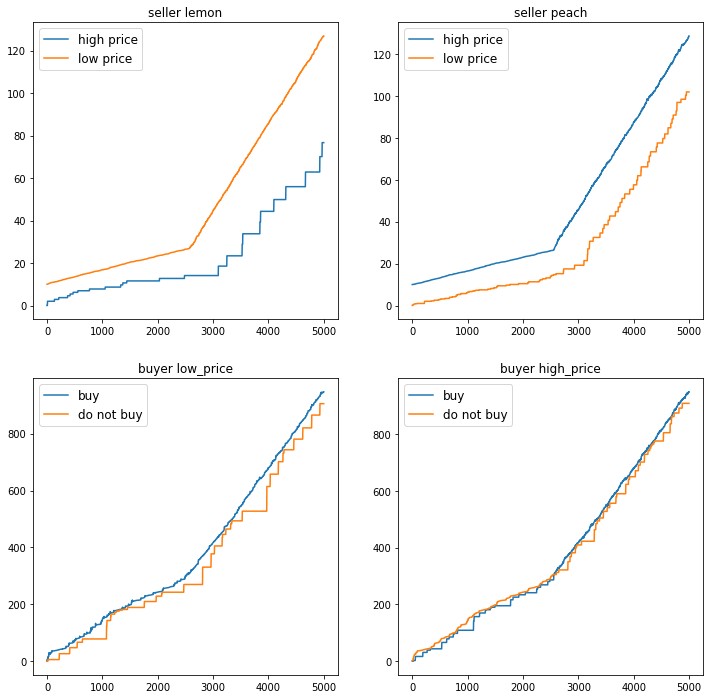

In [320]:
plot_results(qvalues)

Уровень доверия и честности (как меняется скользящее среднее с течением игры):

In [186]:
# lemon-peach, high_price-low_price, buy-not_buy
# honesty: lemon + low_price, peach + high_price
# trust: high_price+buy, low_price+buy

def plot_trust_honesty(stats, rolling_num=20):
    trust = pd.Series((stats[:, 2] == 0).astype(int)).rolling(rolling_num).mean()
    honesty = pd.Series(np.logical_xor(stats[:, 0], stats[:, 1]).astype(int)).rolling(rolling_num).mean()
    lemon_honesty = (
        pd.Series(np.logical_and((stats[:, 0] == 0), (stats[:, 1] == 1))).rolling(rolling_num).sum() / 
        pd.Series((stats[:, 0] == 0).astype(int)).rolling(rolling_num).sum()
    )
    
    f, axarr = plt.subplots(2, 1, figsize=(12, 8))
    axarr[0].plot(range(n_iters), trust, color='blue')
    axarr[0].set_title('trust', fontsize=14)
    axarr[0].grid()

    axarr[1].plot(range(n_iters), honesty, color='green')
    axarr[1].set_title('honesty', fontsize=14)
    axarr[1].grid()
    
    print('% заключенных сделок:', np.sum(stats[:, 2] == 0) / len(stats))
    
    return trust, honesty, lemon_honesty

% заключенных сделок: 0.6118


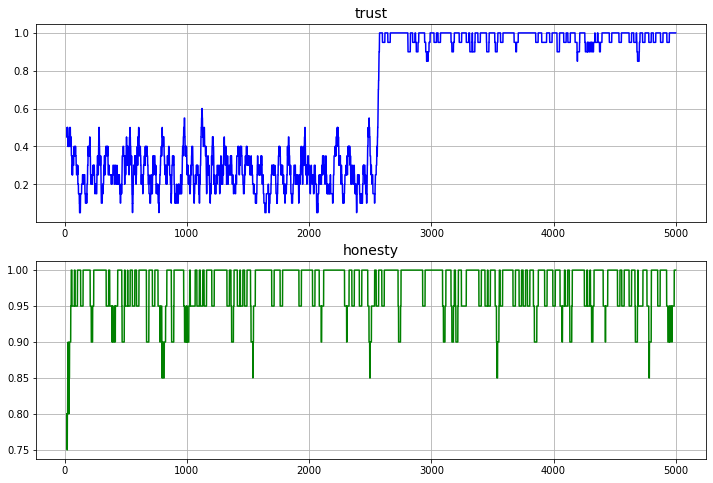

In [321]:
_ = plot_trust_honesty(stats)

$\rightarrow$ С помощью инициализации начальных матриц можно моделировать стратегию игроков по умолчанию и приверженность этой стратегии.

Расссотреть разные абсолютные значения.

1. Нулевая матрица:
2. Честные стратегии:
3. Честность + недоверие:
4. Нечестность + доверие:
5. Нечестность + недоверие:

# Анализ

1. Рассмотрим ситуацию, когда игроки имеют нулевую начальную матрицу, то есть изначально игроки поступают случайным образом и постепенно начинают подбирать оптимальное действие.

Параметры: epsilon=0.5, decay=0.9, min_epsilon=0.05, стратегии сходятся за ~200 розыгрышей.
lr = [0.001, 0.01, 0.1]

$\rightarrow$ Стратегии практически сразу переходят в ситуацию, когда продавец продает и персики, и лимоны по высокой цене, покупатель соглашается покупать только по низкой. Сделки совершаются редко (5%).

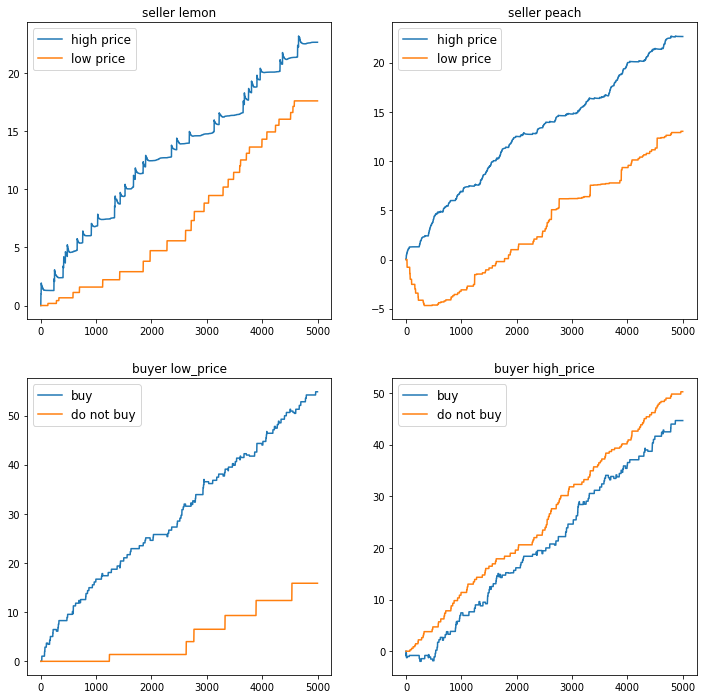

In [162]:
# lr = 0.01
plot_results(qvalues)

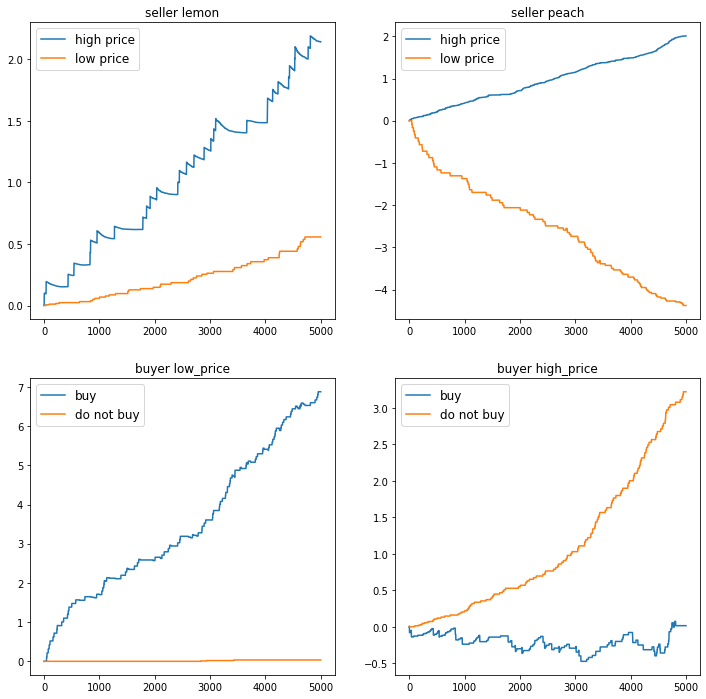

In [178]:
# lr = 0.001
plot_results(qvalues)

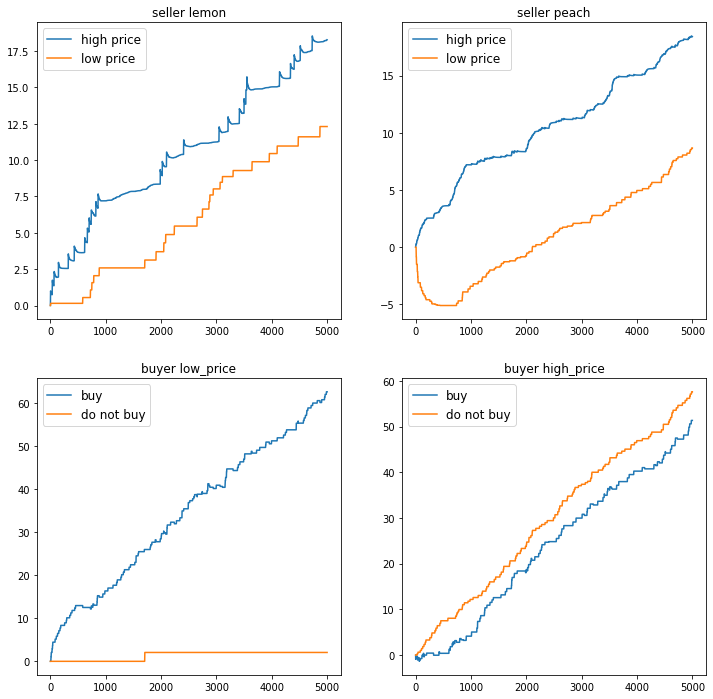

In [188]:
# lr = 0.1
plot_results(qvalues)

2. Матрицы инициализируются честными стратегиями с разными абсолютными значениями.

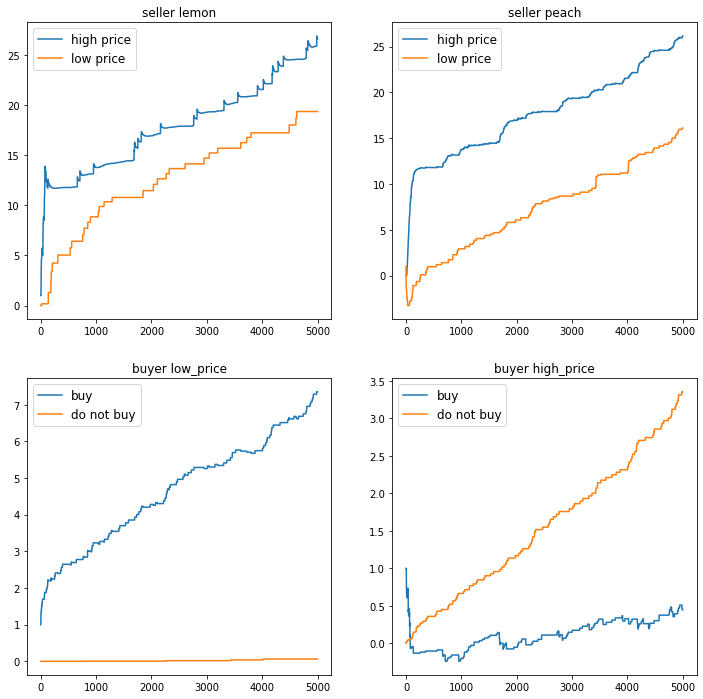

In [192]:
# qval = 1, lr=0.01
plot_results(qvalues)

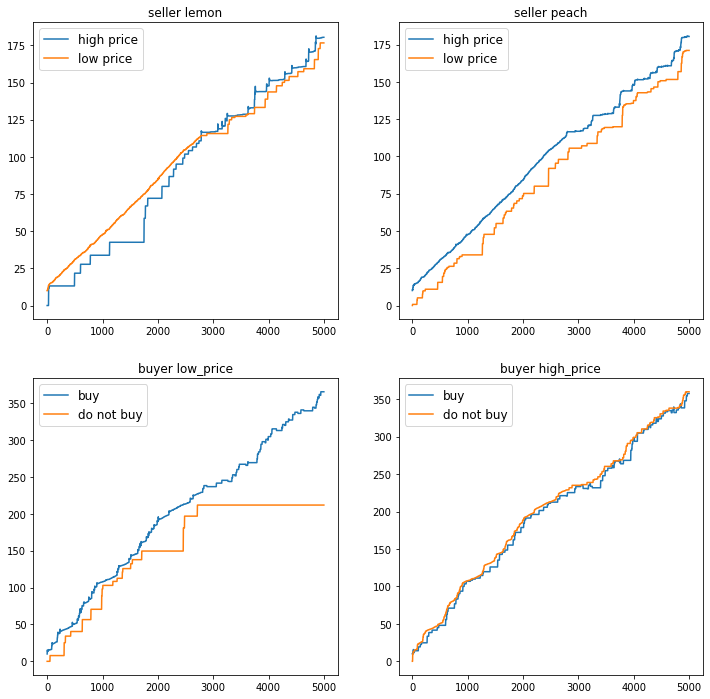

In [215]:
# qval=10, lr=0.5
plot_results(qvalues)

% заключенных сделок: 0.1744


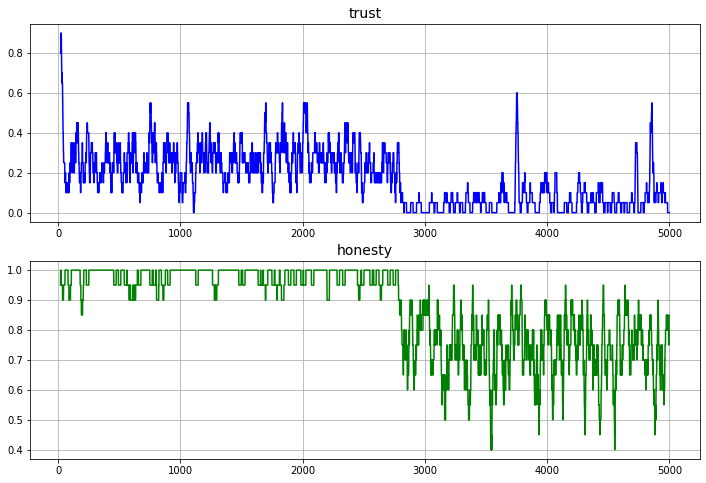

In [216]:
_ = plot_trust_honesty(stats)

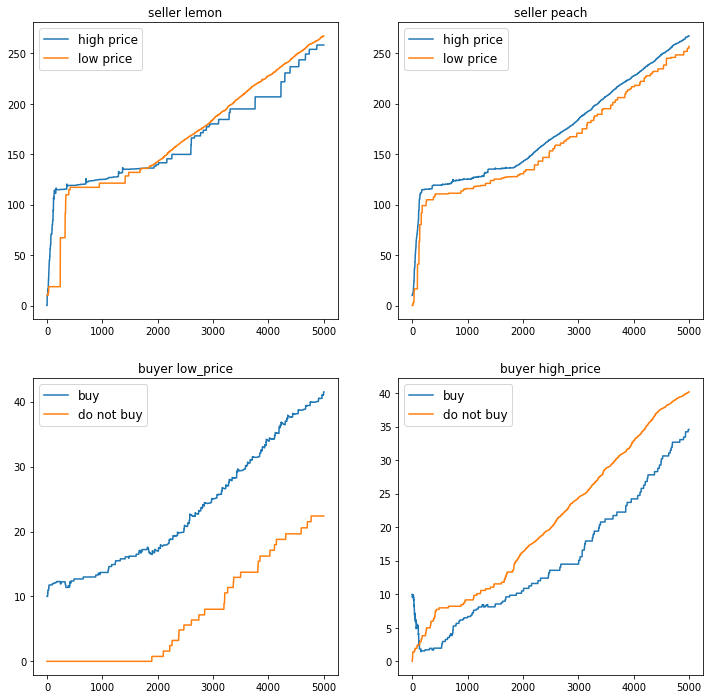

In [225]:
# qval=10, lr=0.5 и 0.05 (buyer)
plot_results(qvalues)

% заключенных сделок: 0.231


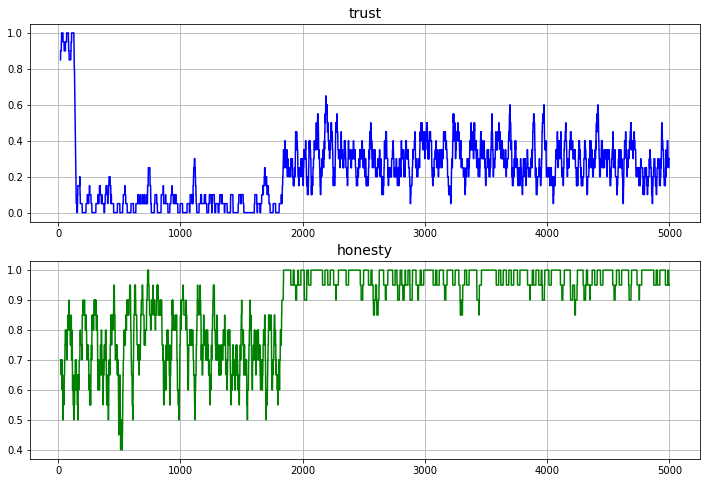

In [226]:
_ = plot_trust_honesty(stats)

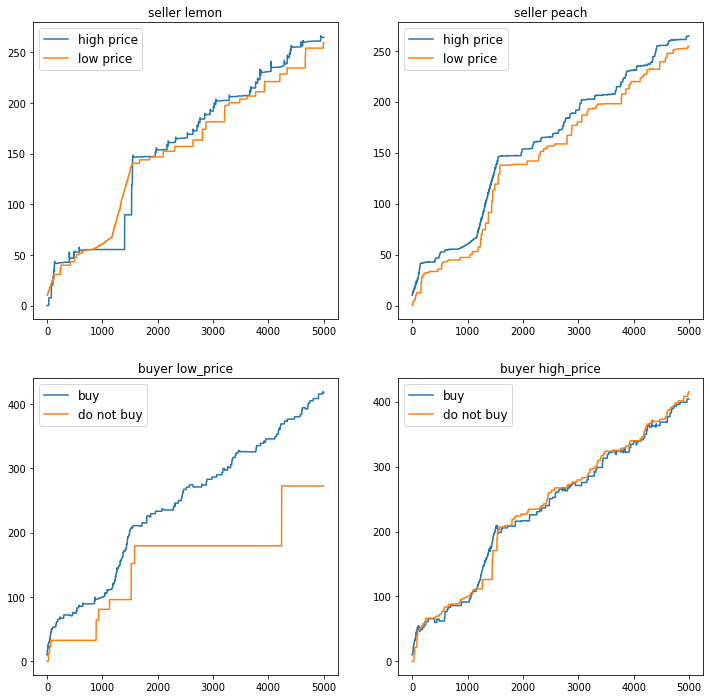

In [228]:
plot_results(qvalues)

% заключенных сделок: 0.1632


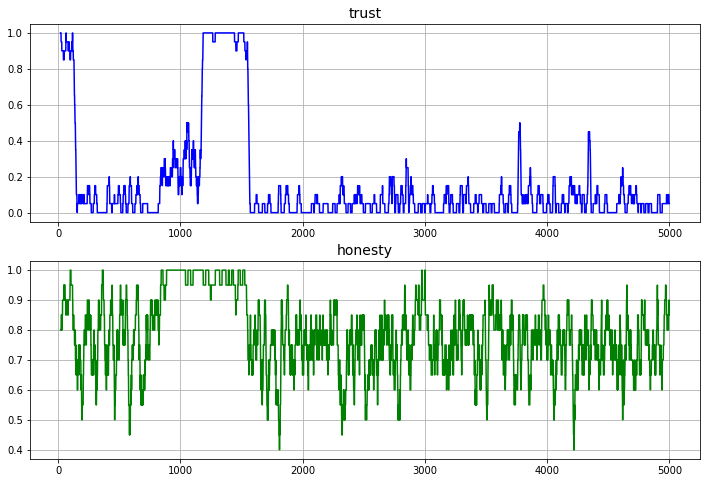

In [229]:
_ = plot_trust_honesty(stats)

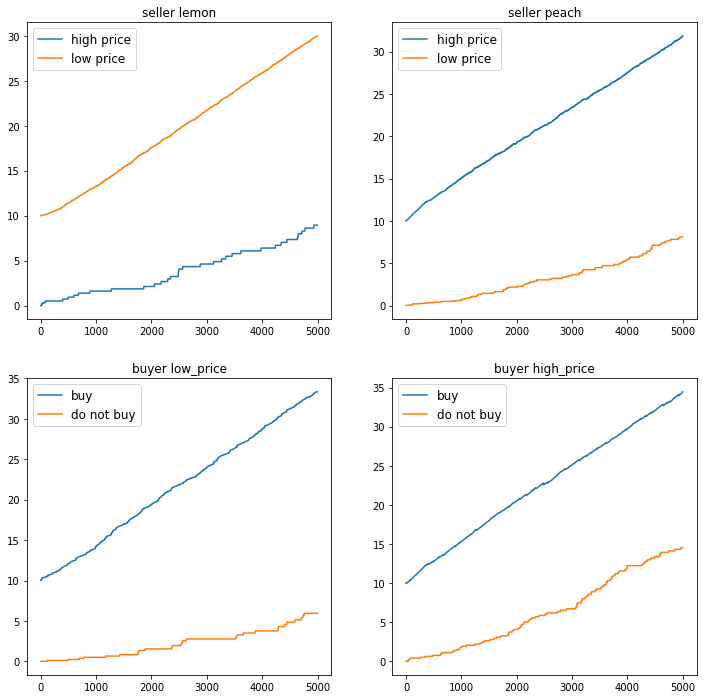

In [231]:
plot_results(qvalues)

% заключенных сделок: 0.9766


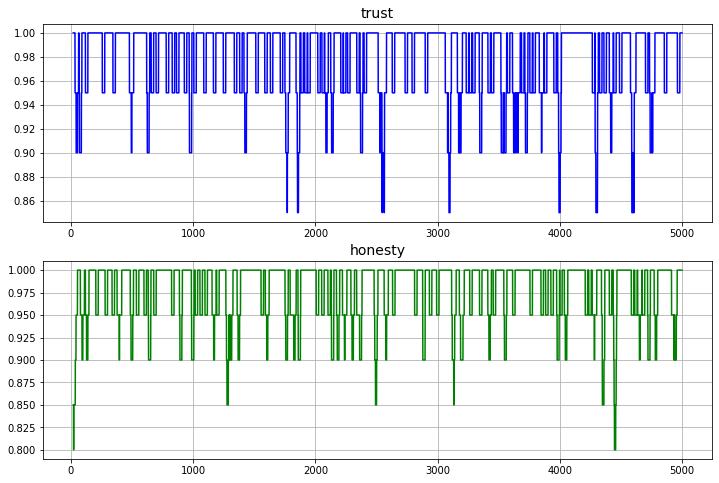

In [232]:
_ = plot_trust_honesty(stats)

$\rightarrow$ Начиная с честной стратегии, чаще всего все сходится к отсутствию сделок.

3. Можно ли от нечестной стратегии прийти к честной?

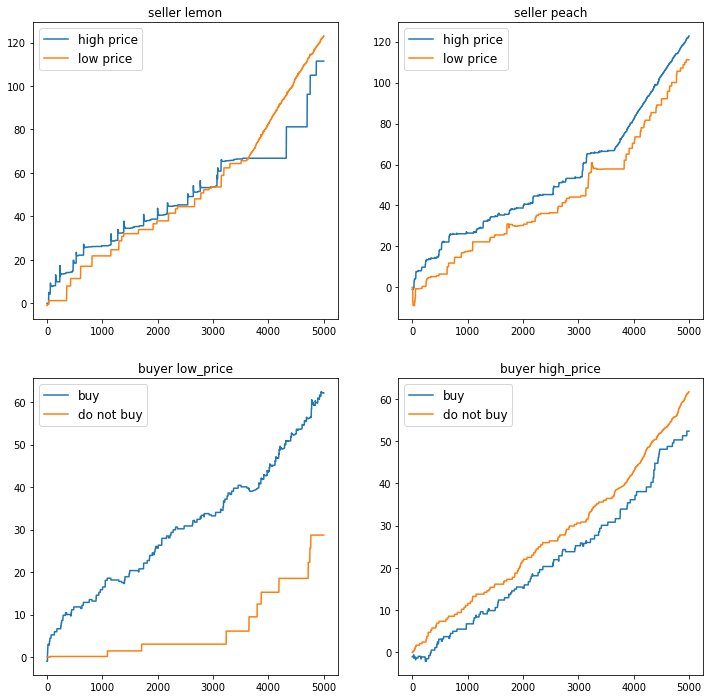

In [250]:
plot_results(qvalues)

% заключенных сделок: 0.12


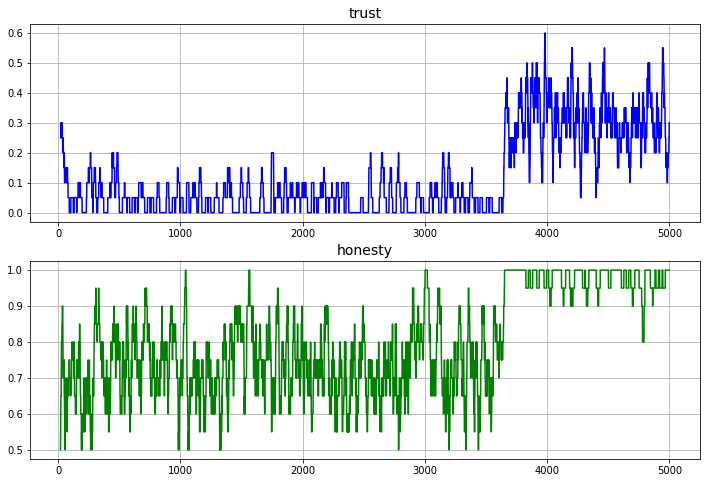

In [251]:
# qval=-1, lr=0.5(seller)&0.1(buyer)
_ = plot_trust_honesty(stats)

$\rightarrow$ Ситуация, когда от нечестной стратегии продавца можно перейти к ситуации, когда продаются только лимоны.

Изучить влияние параметров lr, epsilon, decay, начальная стратегия на поведение игроков.
Эксперименты:
    
Написать игрока, который может быть продавцом и покупателем одновременно.

? Моделировать набор группу игроков.

нужно рассматривать честность только со стороны лимонов